# **프로젝트: 네이버 영화리뷰에 SentencePiece 사용하기**
- 데이터 : [네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)
- 진행 과제
  - 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
  - 학습된 모델로 sp_tokenize() 메소드 구현하기
  - 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
  - (보너스) SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

<span style="color: #f5f0ff">보라</span>
 ***
## <목차>
#### Step 1. 데이터 준비 및 확인
  1. 데이터 준비
  2.  결측치 제거
  3. 데이터 분석

#### STEP2. 공백 기반 토큰화
#### STEP3. 형태소 기반 토큰화
#### STEP4. SentencePiece 사용
  1. SentencePiece 설치하기
  2. SentencePiece 모델 학습
  3. Tokenizer 함수 작성
  
#### STEP5. 재학습
####🤔회고🤔
***
# Step 1. 데이터 준비 및 확인
## (1) 데이터 준비

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pwd

'/content'

In [3]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [80.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [4]:
# 필요 라이브러리 임포트
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models import KeyedVectors
from konlpy.tag import Mecab

# # 데이터 다운로드
# !wget https://github.com/e9t/nsmc/blob/master/ratings_test.txt
# !wget https://github.com/e9t/nsmc/blob/master/ratings_train.txt

In [5]:
# 라이브러리 버전 확인하기
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.8.0
1.21.5
3.2.2
0.6.0


In [6]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.utils import pprint
from konlpy.tag import Mecab
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [7]:
# 데이터 불러오기
train_data = pd.read_table('/content/drive/MyDrive/Aiffel_LMS/Going_Deeper(NLP)/[N-02]Create_a_dictionary/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Aiffel_LMS/Going_Deeper(NLP)/[N-02]Create_a_dictionary/sentiment_classification/data/ratings_test.txt')
# train_data = pd.read_csv('/content/drive/MyDrive/Aiffel_LMS/Going_Deeper(NLP)/[N]Create_a_dictionary/ratings_train.txt', sep = "\t", engine='python' )

# 데이터 확인
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [8]:
type(train_data)

pandas.core.frame.DataFrame

## (2) 결측치 제거
- 결측치(Null) 확인하기
- 결측치 제거해주기

In [9]:
print(train_data.isnull().values.any())

True


In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [11]:
train_data.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [12]:
train_data.loc[train_data['document'].isna()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [13]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [14]:
print('리뷰 개수 :',len(train_data)) # 리뷰 개수 출력

리뷰 개수 : 149995


- 최종 146,182개의 샘플을 naver_review.txt 파일에 저장한 후에 센텐스피스를 통해 단어 집합을 생성합니다.

## (3) 데이터 분석
❗ with open 할 때부터 df를 sen 형식으로 변경해야하는데,,, 어렵네,,,      
따라서 제대로 된 전처리가 지금 되지 않은 듯..


In [21]:
import os
path_to_file = '/content/drive/MyDrive/Aiffel_LMS/Going_Deeper(NLP)/[N-02]Create_a_dictionary/sentiment_classification/data/ratings_train.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


In [22]:
path_to_file

'/content/drive/MyDrive/Aiffel_LMS/Going_Deeper(NLP)/[N-02]Create_a_dictionary/sentiment_classification/data/ratings_train.txt'

- 최단 길이 1인 문장 살펴보기   
  => id와 label이 전부 문장으로 취급되어 최단 길이 1인 문장임에도 8로 나타남   
  => 이는 df 형식을 변경시켜야 함.....


문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


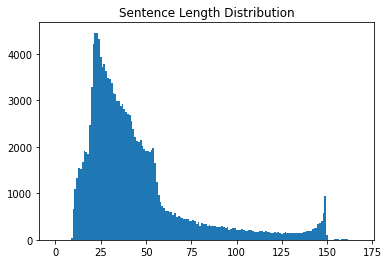

In [17]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [19]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 8)

6859	짱	1


In [24]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40
Outlier Index: 41
Outlier Index: 42
Outlier Index: 43
Outlier Index: 44
Outlier Index: 45
Outlier Index: 46
Outlier Index: 47
Outlier Index: 48
Outlier Index: 49
Outlier Index: 50
Outlier Index: 51
Outlier Index: 52
Outlier Index: 53
Outlier Index: 54
Outlier Index: 55
Outlier Index: 56


In [25]:
check_sentence_with_length(raw, 11)

7348295	아	0
7679615	잼	1
7117896	1	0
6478189	4	0
5890638	4	0
775332	최고	1
3412704	굿	1
7030708	짱	1
7910238	휴	1
423224	^^	1
7957379	.	1
7916532	1	0
7882871	굿	1
6959675	?	1
5452516	?	0
135585	ㅋㅋ	0
7117918	ㅎ	1
1403313	굿	1
7274727	ㅋ	1
7533102	굿	1
4920691	즐	0
7131270	♥	1
190750	당연	1
2310642	굳	1
7774007	ㅋ	0
965357	최고	1
7057331	네	1
7916647	ㅎ	0
4967352	ㅋ	1
775659	쵝오	1
6518265	굿	0
7134446	ㅇ	0
6886740	.	1
2218743	굿	1
6631225	굿	1
7933682	굳	1
23412	잼없다	0
7260203	ㅠ	1
7651117	?	0
7916517	1	0
7092995	ㅋ	1
1640173	굿	0
6931782	쒯	0
4065837	굿	1
3042281	굿	1
136593	gg	1
286425	;;	0
565434	조앙	1
7318841	굳	1
6994608	♬	1
7503404	굿	1
4458814	토	1
7143066	ㅋ	1
7594043	ㅋ	0
7136480	굿	1
7204900	ㅋ	1
7473056	굿	1
6876426	O	1
5873214	똥	0
5087535	ㅎ	0
7028687	.	0
6642272	굿	1
7505484	ㅎ	1
298699	좋음	1
7899011	짱	1
8009978	굳	1
7813306	굿	1
2479318	굿	1
5238354	짱	1
1494330	?	0
7452959	z	0
4886403	굿	1
7402090	짱	1
163702	mm	0
4903820	굳	1
5666738	ㅇ	1
7080841	헐	0
7513278	굳	1
7798656	굳	1
7805364	굿	1
7272767	굿	1
7315331	굿	1
6386670	삼	0
6383

Data Size: 150001
문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


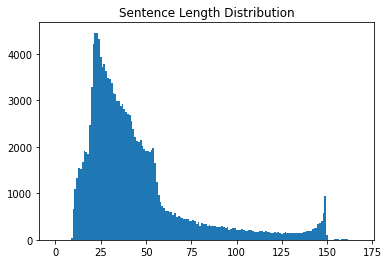

In [26]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


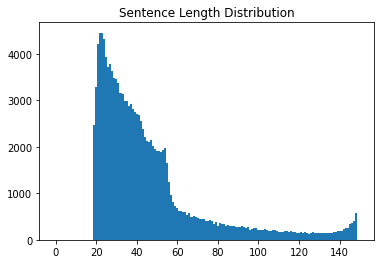

In [28]:
max_len = 150
min_len = 20

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# STEP2. 공백 기반 토큰화

In [33]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [34]:
# 정제된 데이터를 공백 기반으로 토큰화하여 저장하는 코드를 직접 작성해 보세요.
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

- 공백 기반 토큰화를 진행한 후, 단어 사전의 길이를 확인

In [35]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 478002


In [36]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 0
1 : 1
2 : 영화
3 : 너무
4 : 정말
5 : 진짜
6 : 이
7 : 영화.
8 : 왜
9 : 이런
10 : 더
11 : 그냥


# STEP3. 형태소 기반 토큰화

In [37]:
from konlpy.tag import Mecab

mecab = Mecab()
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


In [38]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [39]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 187488


- tokenizer.index_word 를 사용하여 Decoding

In [40]:
# Case 2 : tokenizer.index_word
sentence = ""

for w in mecab_tensor[100]:
    if w == 0: continue
    sentence += mecab_tokenizer.index_word[w] + " "

print(sentence)

8987367 어휴 ㅉㅉ열자이상쓰래 0 


# STEP4. SentencePiece 사용
## (1) SentencePiece 설치하기
- Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer
- BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것
- [google/sentencepiece](https://github.com/google/sentencepiece)

In [42]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 8.3 MB/s 


## (2) SentencePiece 모델 학습
- 공백 기반 토큰화 할 때 했던 tokenize() 함수   
  => tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것
- 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 함

In [44]:
import sentencepiece as spm
import os
temp_file = '/content/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 368156 Mar 24 17:36 korean_spm.model
-rw-r--r-- 1 root root 137548 Mar 24 17:36 korean_spm.vocab


위 코드를 실행하면 정상적으로 SentencePiece 모델 학습이 완료된 후 korean_spm.model 파일과 korean_spm.vocab vocabulary 파일이 생성되었음을 확인할 수 있습니다.

그럼 이렇게 학습된 SentencePiece 모델을 어떻게 활용하는지 살펴보겠습니다.

In [45]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1698, 13, 380, 19, 1555, 13, 132, 23, 5]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## (3) Tokenizer 함수 작성
우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 `sp_tokenize()` 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

1. 매개변수로 토큰화된 문장의 `list`를 전달하는 대신 온전한 문장의 `list` 를 전달합니다.

2. 생성된 vocab 파일을 읽어와 `{ <word> : <idx> }` 형태를 가지는 `word_index` 사전과 `{ <idx> : <word>}` 형태를 가지는 `index_word` 사전을 생성하고 함께 반환합니다.

3. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?


In [46]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [47]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 599 4005   17 1019 2461    5    0    0    0    0]
 [1893 3548  343  544   13    3   20 7935  769   12]]


# STEP5. 재학습

In [48]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_data = train_data.dropna(how = 'any')  # NA값 제거
    
    test_data.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_data = test_data.dropna(how = 'any')  # NA값 제거 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} # 딕셔너리에 {텍스트:인덱스} 구조로 저장
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

print("train: {}, test: {}".format(len(X_train), len(X_test)))

train: 146182, test: 49157


In [49]:
# {텍스트: 인덱스}에서 {인덱스:텍스트}로 변경

index_to_word = {index:word for word, index in word_to_index.items()}

In [50]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [51]:
# 모델 구성을 위한 데이터 가공
total_data_text = list(X_train) + list(X_test)

# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 지정 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [52]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index['<PAD>'],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index['<PAD>'],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


In [53]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

In [54]:
# validation set 10000건 분리
x_val = X_train[:10000]
y_val = y_train[:10000]

partial_x_train = X_train[10000:]
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [55]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 4  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [57]:
# GlobalMaxPooling1D
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 4)           40000     
                                                                 
 global_max_pooling1d (Globa  (None, 4)                0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


In [59]:
model3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = model3.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
266/266 [==============================] - 8s 9ms/step - loss: 0.6430 - accuracy: 0.6852 - val_loss: 0.5350 - val_accuracy: 0.7815
Epoch 2/10
266/266 [==============================] - 2s 9ms/step - loss: 0.4555 - accuracy: 0.8036 - val_loss: 0.4086 - val_accuracy: 0.8171
Epoch 3/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3891 - accuracy: 0.8311 - val_loss: 0.3856 - val_accuracy: 0.8277
Epoch 4/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3646 - accuracy: 0.8427 - val_loss: 0.3782 - val_accuracy: 0.8312
Epoch 5/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3496 - accuracy: 0.8500 - val_loss: 0.3762 - val_accuracy: 0.8308
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3390 - accuracy: 0.8544 - val_loss: 0.3765 - val_accuracy: 0.8338
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3310 - accuracy: 0.8585 - val_loss: 0.3774 - val_accuracy: 0.8328
Epoch 

***
# 🤔회고🤔
## <루브릭 평가 기준>
|평가문항|상세기준|
|---|---|
|1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?|코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?|
|2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?|SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.|
|3. SentencePiece의 성능을 다각도로 비교분석하였는가?|SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.|

## <느낀점>
- 아직 기초가 부족하다.
- 내가 원하는 만큼 하기 위해선 기본적인 노드가 필요하다고 생각하기에 프로젝트 내용들은 추후에 다시 할 것이다.
- 중간 단계없이 갑자기 심화 내용을 제출하라고 하니 당황스러울 뿐이다.